# Importing Relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, InputLayer
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import mobilenet_v2


In [2]:
data = pd.read_csv('Data\\age_gender.csv')
data.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [4]:
data = data.drop(columns='img_name')
data.head()

,age,ethnicity,gender,pixels
0,1,2,0,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,202 205 209 210 209 209 210 211 212 214 218 21...


## Targets are Age, Ethnicity and Gender 
### Set pixels to X and targets to y

In [5]:
cols = ["age", "ethnicity", "gender"]
x = data.drop(columns=cols)
y = data.drop(columns="pixels")

In [6]:
x.head()

,pixels
0,129 128 128 126 127 130 133 135 139 142 145 14...
1,164 74 111 168 169 171 175 182 184 188 193 199...
2,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,193 197 198 200 199 200 202 203 204 205 208 21...
4,202 205 209 210 209 209 210 211 212 214 218 21...


In [7]:
y.head()

,age,ethnicity,gender
0,1,2,0
1,1,2,0
2,1,2,0
3,1,2,0
4,1,2,0


# Data Visualization

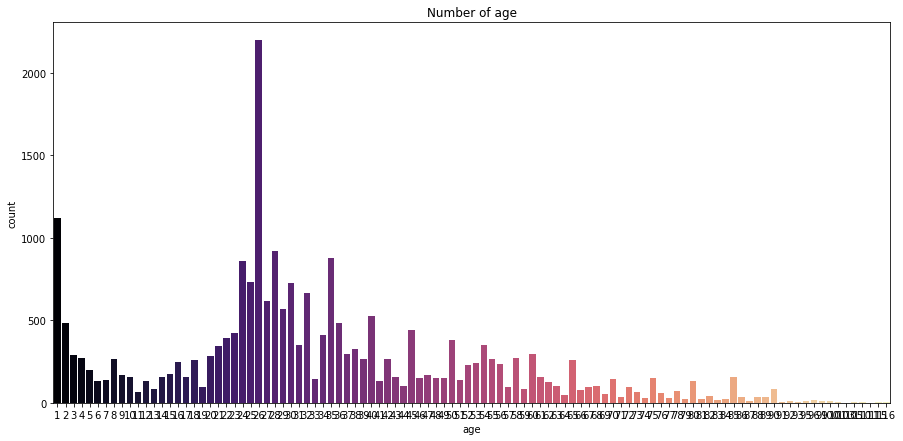

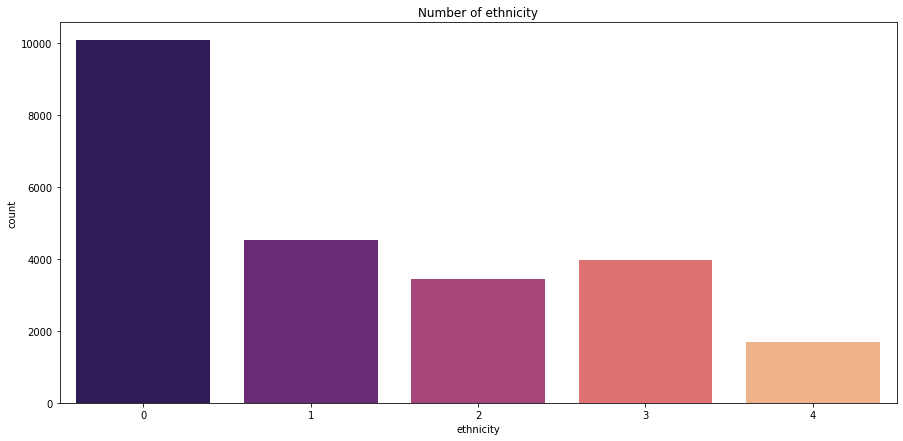

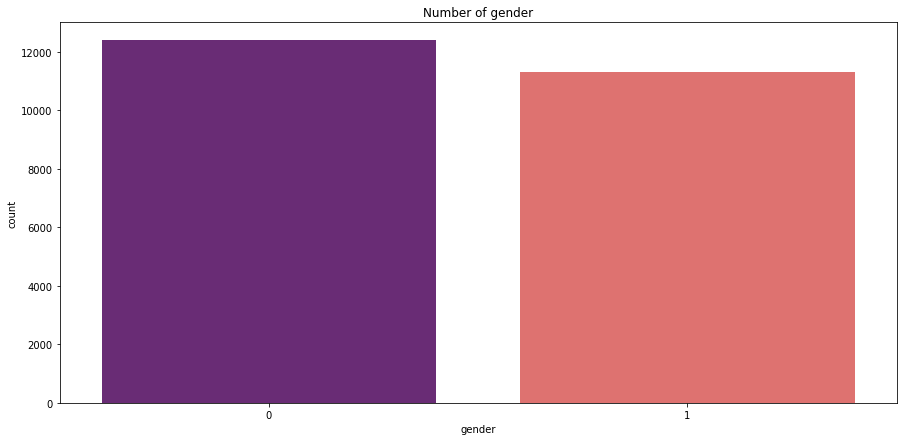

In [8]:
for i in y.columns:
    plt.figure(figsize=(15,7))
    s = sns.countplot(y[i], palette="magma")
    plt.title("Number of {}".format(i))

#### Inferences: 
#### 1. No Gender Bias in the Data.
#### 2. Data is heavily biased towards ethinicity 0.
#### 3. Data is biased towards the 20-40 age interval.

#### Approach:
#### 1. Convert Age to interval as usual with a big bin in the 18-40 range to account for the bias.


Text(0.5, 1.0, 'Age Countplot')

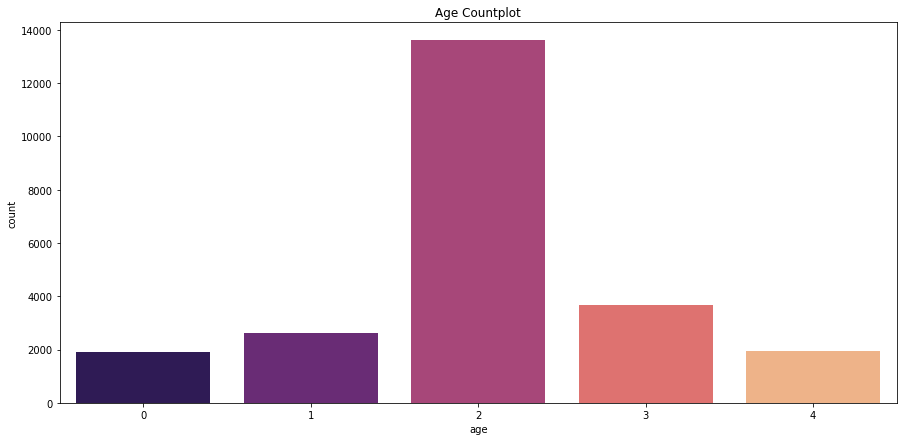

In [9]:
y["age"] = pd.cut(y["age"], bins = [0,3,18,45,64,116], labels=["0", "1", "2", "3", "4"])
plt.figure(figsize=(15,7))
s = sns.countplot(y["age"], palette="magma")
plt.title("Age Countplot")

### Reshaping and Prepping for Modeling

In [10]:
num_pixels = len(x['pixels'][0].split(" "))
img_h = int(np.sqrt(len(x['pixels'][0].split(" "))))
img_w = int(np.sqrt(len(x['pixels'][0].split(" "))))

In [11]:
x = pd.Series(x['pixels'])
x = x.apply(lambda x: x.split(' '))
x = x.apply(lambda x: np.array(list(map(lambda z: np.int(z), x))))
x = np.array(x)
x = np.stack(np.array(x), axis=0)
x = np.reshape(x, (-1, 48, 48))

x = x.reshape(-1, 48, 48, 1)

In [12]:
print(x.shape)

(23705, 48, 48, 1)


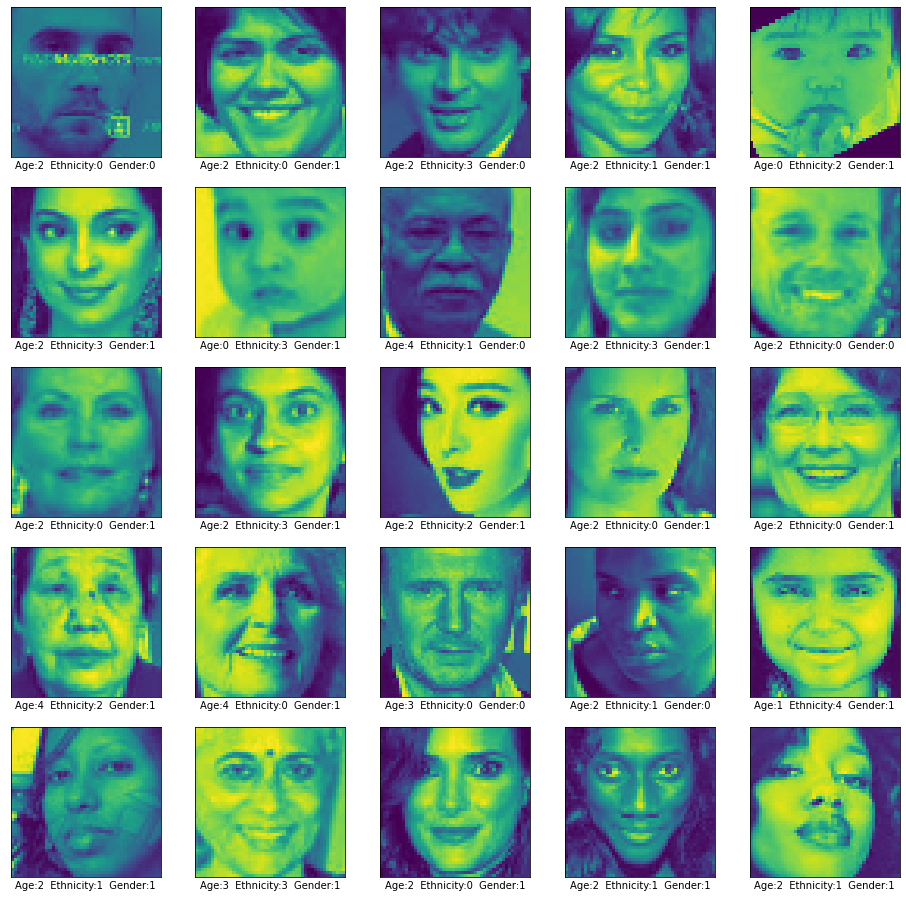

In [13]:
plt.figure(figsize=(16,16))
for i, a in zip(np.random.randint(0, 23705, 25), range(1,26)):
    plt.subplot(5,5,a)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i])
    plt.xlabel(
        "Age:"+str(y['age'].iloc[i])+
        "  Ethnicity:"+str(y['ethnicity'].iloc[i])+
        "  Gender:"+ str(y['gender'].iloc[i])
    )
plt.show()

In [14]:
age_series = np.array(y['age'])
gender_series = np.array(y['gender'])
ethnic_series = np.array(y['ethnicity'])
age_df = to_categorical(age_series, num_classes=5)
gender_df = to_categorical(gender_series, num_classes=2)
ethnic_df = to_categorical(ethnic_series, num_classes=5)


In [15]:
x = x/255.0

In [16]:
datagen = ImageDataGenerator(
        preprocessing_function= mobilenet_v2.preprocess_input, validation_split=0.2,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images



In [17]:
from sklearn.model_selection import train_test_split
seed = 50
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(x, ethnic_df, test_size=0.1, random_state=seed) 


In [18]:
def my_model(num_classes, activation, loss):
    model = Sequential() 
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = "same", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = "same"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation= activation))
    model.compile(optimizer='Adam',
              loss= loss,
              metrics=['accuracy'])
    return model

In [19]:
early_stopping = EarlyStopping(patience=10, min_delta=0.001,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                            factor=0.5, min_lr=0.00001)

In [20]:
epochs = 200  # for better result increase the epochs
batch_size = 64
model_ethnicity = my_model(5,"softmax",'categorical_crossentropy')
history_ethnicity = model_ethnicity.fit(X_train_e, y_train_e, batch_size=batch_size,
                              epochs = epochs, validation_data = (X_test_e,y_test_e), steps_per_epoch= X_train_e.shape[0] // batch_size, callbacks= [early_stopping, learning_rate_reduction])

Epoch 1/200
333/333 [==============================] - 5s 6ms/step - loss: 1.1056 - accuracy: 0.6037 - val_loss: 1.2367 - val_accuracy: 0.5386
Epoch 2/200
333/333 [==============================] - 2s 5ms/step - loss: 0.7987 - accuracy: 0.7252 - val_loss: 0.8178 - val_accuracy: 0.7389
Epoch 3/200
333/333 [==============================] - 2s 5ms/step - loss: 0.7157 - accuracy: 0.7528 - val_loss: 0.6663 - val_accuracy: 0.7697
Epoch 4/200
333/333 [==============================] - 2s 5ms/step - loss: 0.6414 - accuracy: 0.7811 - val_loss: 0.6421 - val_accuracy: 0.7760
Epoch 5/200
333/333 [==============================] - 2s 5ms/step - loss: 0.5995 - accuracy: 0.7943 - val_loss: 0.6621 - val_accuracy: 0.7765
Epoch 6/200
333/333 [==============================] - 2s 5ms/step - loss: 0.5474 - accuracy: 0.8118 - val_loss: 0.7236 - val_accuracy: 0.7516
Epoch 7/200
333/333 [==============================] - 2s 5ms/step - loss: 0.5157 - accuracy: 0.8207 - val_loss: 0.6345 - val_accuracy: 0.7765

In [21]:
import plotly.express as px
fig = px.line(
    history_ethnicity.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}, 
    title='Training History')
fig.show()